In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

import sys
from pathlib import Path
from keras import mixed_precision
# Enables the card's high-speed FP16 cores
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src import dataset

print("Physical Devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.random.set_seed(42)
np.random.seed(42)

2026-01-17 14:25:30.563987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


2026-01-17 14:25:32.684623: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:32.684675: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:33.478564: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:33.478607: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:33.478635: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [2]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
LR = 1e-4

In [3]:
train_ds, val_ds, test_ds, class_weights = dataset.create_datasets(IMAGE_HEIGHT,IMAGE_WIDTH,BATCH_SIZE)

Number of images:  16970
Attributes:  ['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured']

Number of annotations (they refer to images): 16970
Attributes:  ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']

IDs don't always match!
17011 != 17000
Size of paths and labels should be the same:  16970 16970 0
Training samples: 10182
Validation samples: 3394
Testing samples: 3394


2026-01-17 14:25:44.753184: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:44.753276: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:44.753310: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:44.753605: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-17 14:25:44.753638: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

2026-01-17 14:25:55.687518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 1851 of 10182
2026-01-17 14:26:05.688639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3695 of 10182
2026-01-17 14:26:25.684671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7285 of 10182
2026-01-17 14:26:35.690749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 9083 of 10182
2026-01-17 14:26:41.809199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


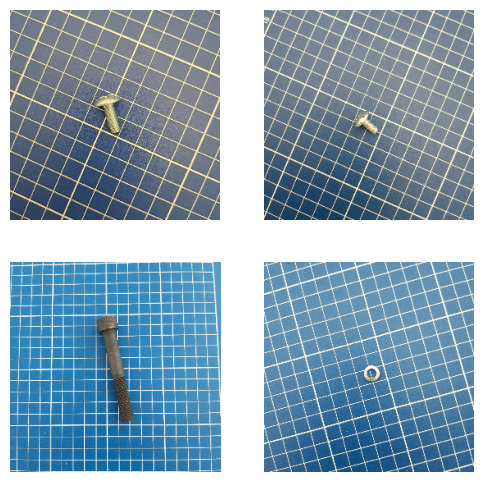

2026-01-17 14:26:41.906752: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6,6))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()

In [5]:
def build_milicevic_model(num_classes,image_width,image_height):
    inputs = keras.Input(shape=(image_width, image_height, 3))
    x = layers.Rescaling(1./255)(inputs)

    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
        ]
    )

    x = data_augmentation(x)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)  
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)  

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model




In [6]:
def create_fastener_model(num_classes, image_width,image_height):
    model = models.Sequential([
        # --- 1. Preprocessing & Augmentation ---
        layers.Input(shape=(image_width, image_height, 3)),
        
        # Normalize pixel values to [0, 1]
        layers.Rescaling(1./255),
        
        # Augmentation: Crucial since fasteners are "not aligned"
        # This makes the model invariant to rotation and orientation
        layers.RandomFlip("horizontal_vertical"),
        layers.RandomRotation(0.2), # Rotates images randomly during training
        layers.RandomZoom(0.1),

        # --- 2. Feature Extraction (Convolutional Blocks) ---
        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 4 (Deeper features for complex fastener threads/heads)
        layers.Conv2D(256, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 5
        layers.Conv2D(512, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # --- 3. Classifier Head ---
        # GlobalAveragePooling reduces parameters significantly compared to Flatten
        layers.GlobalAveragePooling2D(),
        
        # Dense layer with Dropout to prevent overfitting
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        # Output Layer: 6 categories
        layers.Dense(num_classes),

        # Step 2: Manually force the Activation to be float32
        layers.Activation('softmax', dtype='float32')
    ])
    
    return model



In [7]:
def create_fastener_resnet_model(num_classes, width, height):
    # 1. Force standard Python int types
    # This resolves the 'tuple vs int' conflict if variables are numpy types or tuples
    w, h = int(width), int(height)
    
    # 2. Define Input with explicit shape
    inputs = keras.Input(shape=(w, h, 3))

    # --- Data Augmentation ---
    x = layers.RandomRotation(0.5)(inputs)
    x = layers.RandomFlip("horizontal_and_vertical")(x)
    x = layers.Rescaling(1.0/255)(x)

    # --- Initial Convolution ---
    # Using explicit tuple (7, 7) for kernel size is safer in Keras 3
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # --- ResNet Block Definitions ---
    def identity_block(tensor, filters):
        shortcut = tensor
        x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    def projection_block(tensor, filters, strides=2):
        shortcut = tensor
        # Main path
        x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)(tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        # Shortcut path (Projection)
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # --- Build Architecture ---
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = projection_block(x, 128)
    x = identity_block(x, 128)

    x = projection_block(x, 256)
    x = identity_block(x, 256)

    x = projection_block(x, 512)
    x = identity_block(x, 512)

    # --- Output Head ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x) 
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="FastenerResNet")

In [8]:
model = create_fastener_resnet_model(6,IMAGE_WIDTH,IMAGE_HEIGHT)
model.summary()

Model: "FastenerResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ random_rotation[… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,408 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]  

 Total params: 11,189,190 (42.68 MB)

 Trainable params: 11,179,590 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
callbacks_list = [
    # Stop training if validation loss stops improving for 10 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=50, 
        restore_best_weights=True
    ),
    # Reduce learning rate if accuracy plateaus
    
]

In [11]:
history = model.fit(train_ds,
epochs=100,
validation_data=val_ds,
class_weight=class_weights,
callbacks=callbacks_list)


Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 87s 208ms/step - accuracy: 0.5082 - loss: 1.4311 - val_accuracy: 0.1326 - val_loss: 3.6670
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.6998 - loss: 0.8488 - val_accuracy: 0.6152 - val_loss: 1.0355
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.7554 - loss: 0.6761 - val_accuracy: 0.6002 - val_loss: 1.4529
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.7934 - loss: 0.5739 - val_accuracy: 0.3989 - val_loss: 2.7800
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.8090 - loss: 0.5258 - val_accuracy: 0.5407 - val_loss: 1.4976
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 146ms/step - accuracy: 0.8268 - loss: 0.4637 - val_accuracy: 0.4039 - val_loss: 2.7853
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 146ms/step - accuracy: 0.8355 - loss: 0.4350 - val_accuracy: 0.4676 - val_loss: 2.8849
Epoch 8/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.8363 -

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.9502 - loss: 0.1342
Test accuracy: 0.950


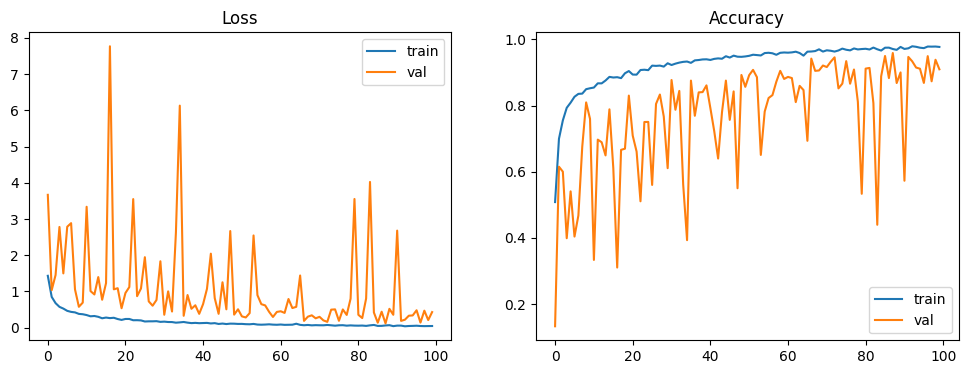

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.savefig("new_model_training_plot.png")

plt.show()


In [14]:
model.save("my_model.keras")